# Phase resolved spectroscopy of Type C QPO toy dataset

## Loading dataset

In [1]:
import astropy
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians, fit_crossspectrum
from scipy.stats import binned_statistic
from scipy.fftpack import fft, ifft

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
type_c = "./toy_TypeC_lightcurve.fits"

lc_fits = Table.read(type_c)
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
n_chans = meta['DETCHANS']
lc_fits
1/(n_seg*dt)

<Table length=8192>
name  dtype   shape   unit             description           
---- ------- ------- ------ ---------------------------------
 REF float64   (50,) ct / s       Reference band light curves
  CI float64 (5, 50) ct / s Channels of interest light curves
None
OrderedDict([('N_BINS', 8192), ('DT', 0.0078125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Documents/GitHub/gsoc18/epoch5_chbinfile.txt'), ('N_SEG', 50), ('NSECONDS', 64.0), ('INFILE', "['tlist_1.fits']"), ('OBJECT', 'GX_339-4')])


2.56

In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
print(ref.shape, ci.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape)

(50, 8192) (50, 5, 8192)
(409600,) (5, 409600)


## Plotting light curve and averaged power spectrum of reference band

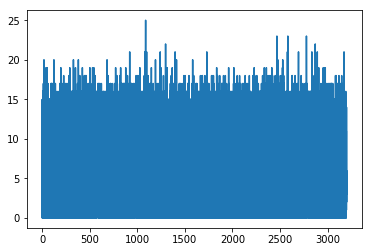

In [4]:
# rearranging reference band segments
ref_counts = np.hstack(ref)
ref_times = np.arange(0, n_seconds*n_seg, dt)

# plotting reference band lightcurve
ref_lc = Lightcurve(ref_times, ref_counts, dt=dt)
ref_lc.plot()

In [5]:
# plotting power spectrum of reference band
ref_aps = AveragedPowerspectrum(ref_lc, norm='leahy',segment_size=n_seg) # absolute normalisation

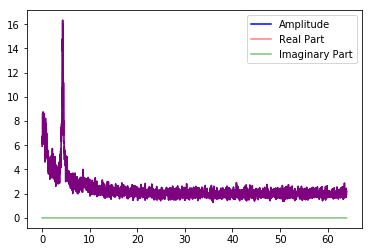

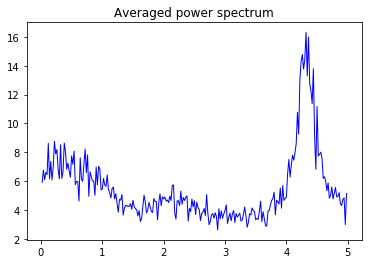

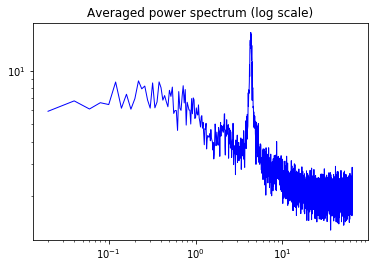

In [6]:
n = len(ref_aps.freq)
range_start, range_stop = int(0*n/64), int(5*n/64)

ref_aps.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')

plt.figure()
plt.title("Averaged power spectrum (log scale)")
plt.loglog(ref_aps.freq, np.abs(ref_aps.power), lw=1, color='blue')

In [7]:
# function to get new df - description missing
def get_new_df(ps):
    lin_psd, f_bin_edges, something = binned_statistic(ps.freq, ps.power[0:int(ps.n/2+1)], 
                                statistic='mean', bins=1600)
    new_df = np.median(np.diff(f_bin_edges))
    return new_df

0.34


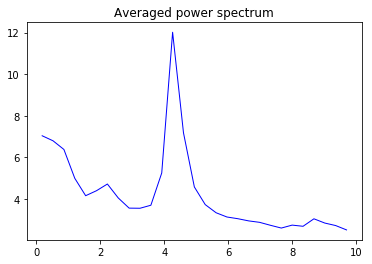

In [8]:
df_new = 0.34
print(df_new)
ref_aps_reb = ref_aps.rebin(df=df_new)

n = len(ref_aps_reb.freq)
range_start, range_stop = int(0*n/64), int(10*n/64)

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps_reb.freq[range_start:range_stop], (np.abs(ref_aps_reb.power))[range_start:range_stop], lw=1, color='blue')

## Fitting Lorentzian models
1. Two lorentzians (one for each component)
2. 1 Power Law (soft?)
3. Constant

[10.6662467   4.33969043  0.43946635  0.48293544  8.74072183  0.59346048
  2.05561047  2.1885176   0.53775334  1.55922191]


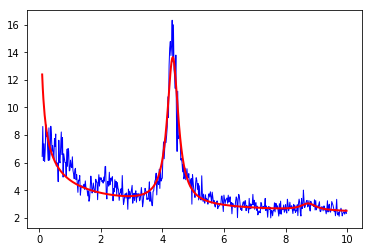

In [9]:
model_to_test = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps, model_to_test, fitmethod="CG")
res_model, res_pars = res.model, res.model.parameters

# print(res_model)
print(res_pars)

n = len(ref_aps.freq)
range_start, range_stop = int(0.1*n/64), int(10*n/64)

plt.figure()
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(res_model(ref_aps.freq))[range_start:range_stop], lw=2, color="red")

### Determining new N

In [10]:
def nearest_power_of_2(x):
    x = int(x)
    x_lower = 1 if x == 0 else 2**(x - 2).bit_length()
    x_upper = 1 if x == 0 else 2**(x - 1).bit_length()
    return x_lower if (x - x_lower) < (x_upper - x) else x_upper

In [11]:
fwhm = res_model[0].fwhm.value
new_n_bins = nearest_power_of_2(1/(fwhm*dt))
new_n_seg = int(n_bins*n_seg/new_n_bins)
print("current N:", n_bins)
print("new N:", new_n_bins)
print("current M:", n_seg)
print("new M:", new_n_seg)
n_bins/new_n_bins
df_old = 1/(n_bins*dt)
df_new = fwhm
dt_new = 1/new_n_bins/df_new
df_old, df_new, dt_new

current N: 8192
new N: 512
current M: 50
new M: 800


(0.015625, 0.4394663525597359, 0.004444310670484187)

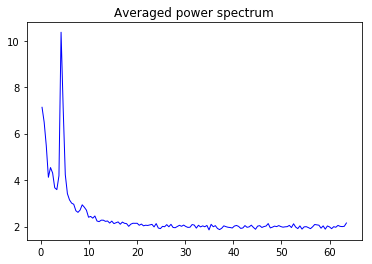

In [12]:
# plotting power spectrum of reference band
ref_aps_new = ref_aps.rebin(df=df_new)

n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(64*n/64)

# ref_aps_new.plot()

plt.figure()
plt.title("Averaged power spectrum")
plt.plot(ref_aps_new.freq[range_start:range_stop], (np.abs(ref_aps_new.power))[range_start:range_stop], lw=1, color='blue')


[9.27063114 4.33993871 0.55780394 0.48045882 8.76874631 0.83146507
 1.94320769 2.10602074 0.6255599  1.6826743 ]


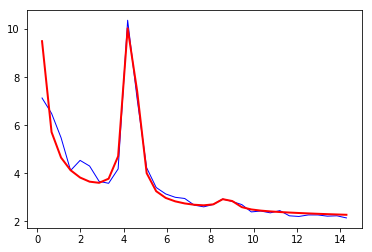

In [13]:
model_to_test = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps_new, model_to_test, fitmethod="CG")
res_model_new, res_pars_new = res.model, res.model.parameters
    
# print(res_model_new)
print(res_model_new.parameters)

n = len(ref_aps_new.freq)
range_start, range_stop = int(0*n/64), int(15*n/64)

plt.figure()
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(ref_aps_new.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps_new.freq[range_start:range_stop], np.abs(res_model_new(ref_aps_new.freq))[range_start:range_stop], lw=2, color="red")

In [14]:
def calculate_rms(ps, model):
    """ function to get fitting model used to calculate rms based on the type of filter used. """
    freq = ps.freq # replace this with self.freq later
    model_output = model(freq>=0) # paper: "the integral from zero to infinity of a Lorentzian component gives the squared rms in that component"
    df = freq[1]-freq[0]
    rms = np.sqrt(np.sum(model_output * df))
    return rms

In [15]:
avg_sigma_1 = calculate_rms(ref_aps_new, res_model_new[0]) # 1st harmonic Lorentzian
avg_sigma_2 = calculate_rms(ref_aps_new, res_model_new[1]) # 2nd harmonic Lorentzian
avg_sigma_1, avg_sigma_2

(2.022579579908769, 0.2956766461365352)

### Phase Difference

In [22]:
x = ref_counts/dt
X = fft(x) # fourier transform of count rate

X_1 = X[0] # 1st harmonic
X_2 = X[1] # 2nd harmonic

small_phi_1 = np.angle(X_1)
small_phi_2 = np.angle(X_2)
small_phi_1, small_phi_2, X[0], X[1]

409600 409600


(0.0,
 -0.17485745327529434,
 (316625536+0j),
 (985769.6781618742-174147.66623433298j))

In [17]:
cap_phi_1 = small_phi_1
cap_phi_2 = small_phi_2

In [18]:
# mean count rate
mu = np.mean(ref_counts/dt)
mu

773.0115625

# QPO Waveform

In [19]:
def wave(x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2):
    y = mu * (1 + np.sqrt(2) * (avg_sigma_1 * np.cos(x - cap_phi_1) + avg_sigma_2 * np.cos(2*x - cap_phi_2)))
    return y

In [20]:
wave_x = np.linspace(0., 10., 100)
wave_y = wave(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

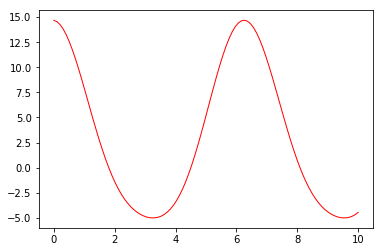

In [21]:
plt.figure()
plt.plot(wave_x, wave_y*dt_new, lw=1, color='red')